# transfer learning with tensorflow part 1: feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

there are two main benefits:
* can leverage an existing neural network architecture proven to work on similar problems
* can leverage its learned patterns, then we can adapt those patterns to our own

In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Jun  4 06:48:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## download and become one with the data

In [2]:
# get data (10% of 10 food classes)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-06-04 06:48:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   178MB/s    in 0.9s    

2022-06-04 06:48:29 (178 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for root, dirs, files in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirs)} directories and {len(files)} files in folder "{root}"')

there are 2 directories and 0 files in folder "10_food_classes_10_percent"
there are 10 directories and 0 files in folder "10_food_classes_10_percent/train"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/chicken_curry"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/steak"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/sushi"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/fried_rice"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/ice_cream"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/hamburger"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/chicken_wings"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/ramen"
there are 0 directories and 75 files in folder "10_food_classes_10_percent/train/pizza"
there are 0 directorie

In [4]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [5]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = [item.name for item in data_dir.glob('*')]
class_names = sorted(class_names)
class_names = np.array(class_names)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [6]:
# let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

  print(f'Image shape: {img.shape}')

  return img

['453376.jpg']
Image shape: (512, 384, 3)


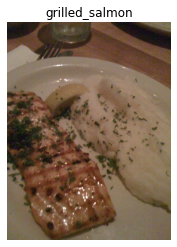

In [7]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## create data loaders

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  #  rotation_range=0.2,
                                  #  shear_range=0.2,
                                  #  zoom_range=0.2,
                                  #  width_shift_range=0.2,
                                  #  height_shift_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1/255)

In [10]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## set up callbacks (things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed during or after training. some of the most popular callbacks:

* Tracking experiments with the tensorboard callback
* Model checkpoint with the modelcheckpoint callback
* stopping a model from training (before it trains too long and overfits) with the earlyStopping callback

In [23]:
# Create Tensorboard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboard log files to: {log_dir}')
  return tensorboard_callback

## creating model using tensorflow hub

we ca access pretrained models on https://tfhub.dev

browsing the tensorflow hub page and sorting for image classification, we fiybd tge following feature vector model
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [12]:
# let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [13]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  takes a tensorflow hub url and creates a Keras Sequential model with it.

  Args:
    model_url (str): A tensorflow hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer, 
    should be equal to the number of target classes, default to 10
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature feature extractor layer
    and Dense output layer with num_classes output neurons
  """
  # download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned pattern
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  # create our own model
  model = tf.keras.Sequential([
                  feature_extractor_layer,
                  layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Creating and testing Resnet TensorFlow Hub feature extraction model

In [15]:
# create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)


In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='Adam',
                     metrics=['accuracy'])

In [24]:
history_1 = resnet_model.fit(train_data,
                 epochs=5,
                 validation_data=test_data,
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                        experiment_name='resnet_50_v2')]
                 )

saving tensorboard log files to: tensorflow_hub/resnet_50_v2/20220604-070157
Epoch 1/5
24/24 [==============================] - 17s 712ms/step - loss: 0.3160 - accuracy: 0.9360 - val_loss: 0.6646 - val_accuracy: 0.7792
Epoch 2/5
24/24 [==============================] - 16s 681ms/step - loss: 0.2614 - accuracy: 0.9560 - val_loss: 0.6539 - val_accuracy: 0.7836
Epoch 3/5
24/24 [==============================] - 16s 676ms/step - loss: 0.2203 - accuracy: 0.9720 - val_loss: 0.6463 - val_accuracy: 0.7828
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.1896 - accuracy: 0.9813 - val_loss: 0.6318 - val_accuracy: 0.7856
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.1637 - accuracy: 0.9867 - val_loss: 0.6422 - val_accuracy: 0.7848


> Wow! that is incredible, our transfer learning feature extractor out performed ALl of the previous models we built by hand.. substantially and in a quicker training tiem And only 10% of the training example

In [25]:
# plot the validation and training curves separately
def plot_loss_curves(history):
  """
  returns separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

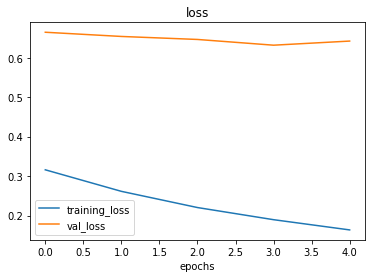

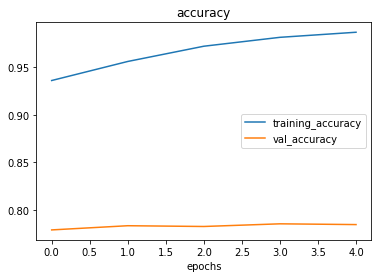

In [26]:
plot_loss_curves(history_1)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [27]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [28]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [29]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

In [30]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              validation_data=test_data,
                                              callbacks=[create_tensorboard_callback('tensorflow_hub', 'efficientnet')])

saving tensorboard log files to: tensorflow_hub/efficientnet/20220604-071750
Epoch 1/5
24/24 [==============================] - 25s 706ms/step - loss: 1.8035 - accuracy: 0.4613 - val_loss: 1.2534 - val_accuracy: 0.7672
Epoch 2/5
24/24 [==============================] - 15s 645ms/step - loss: 1.0398 - accuracy: 0.7813 - val_loss: 0.8388 - val_accuracy: 0.8336
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.7457 - accuracy: 0.8307 - val_loss: 0.6794 - val_accuracy: 0.8524
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.6023 - accuracy: 0.8653 - val_loss: 0.5959 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 15s 642ms/step - loss: 0.5080 - accuracy: 0.8947 - val_loss: 0.5490 - val_accuracy: 0.8632


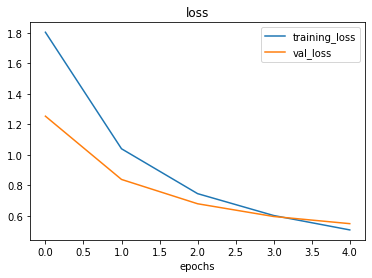

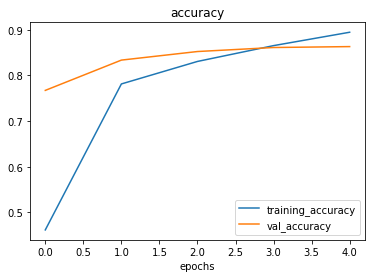

In [32]:
plot_loss_curves(efficientnet_history)

In [36]:
# how many layers does our efficientNetB feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes whatsoever (e.g. output 1000 classes)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem (e.g. 10 classes)
* "Fine-tuning" transfer learning - use the prelearnt patterns of an existing model and "find-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 😀 When you upload things to Tensorboard.dev, your experiments are public. So if you running private experiments, do not upload.

In [40]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training dataset" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/OJNC7MglTyuPCVkPRr1OqA/

[2022-06-04T08:08:07] Started scanning logdir.
[2022-06-04T08:08:12] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2022-06-04T08:08:12] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/OJNC7MglTyuPCVkPRr1OqA/


Our tensorBoard experiements are uploaded here:
https://tensorboard.dev/experiment/9sOvFJSpT7C1kOvKVyM81w/#scalars


In [38]:
# checkout what tensorboard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/9sOvFJSpT7C1kOvKVyM81w/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training dataset
	Id                   9sOvFJSpT7C1kOvKVyM81w
	Created              2022-06-04 07:59:37 (7 minutes ago)
	Updated              2022-06-04 07:59:42 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
Total: 1 experiment(s)


In [39]:
# delete an experiment
!tensorboard dev delete --experiment_id 9sOvFJSpT7C1kOvKVyM81w

Deleted experiment 9sOvFJSpT7C1kOvKVyM81w.
